# Bulk RNA-seq generate 'interrupted' cells to interpolate scRNA-seq

The limited number of cells available for single-cell sequencing has led to 'interruptions' in the study of cell development and differentiation trajectories. In contrast, bulk RNA-seq sequencing of whole tissues contains, in principle, 'interrupted' cells. To our knowledge, there is no algorithm for extracting 'interrupted' cells from bulk RNA-seq. There is a lack of tools that effectively bridge the gap between bulk-seq and single-seq analyses.

We developed BulkTrajBlend in OmicVerse, which is specifically designed to address cell continuity in single-cell sequencing.BulkTrajBlend first deconvolves single-cell data from Bulk RNA-seq and then uses a GNN-based overlapping community discovery algorithm to identify contiguous cells in the generated single-cell data.

Colab_Reproducibility：https://colab.research.google.com/drive/1HulVXQIlUEcpGRDZo4MxcHYOjnVhuCC-?usp=sharing


In [2]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 04日 星期一 16:51:07 CST


## loading data

For illustration, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

We utilized single-cell RNA-seq data (GEO accession: GSE95753) obtained from the dentate gyrus of the hippocampus in rats, along with bulk RNA-seq data (GEO accession: GSE74985). 

In [3]:
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
import numpy as np
bulk=ov.utils.read('data/GSE74985_mergedCount.txt.gz',index_col=0)
bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,dg_d_1,dg_d_2,dg_d_3,dg_v_1,dg_v_2,dg_v_3,ca4_1,ca4_2,ca4_3,ca3_d_1,...,ca3_v_3,ca2_1,ca2_2,ca2_3,ca1_d_1,ca1_d_2,ca1_d_3,ca1_v_1,ca1_v_2,ca1_v_3
Tbata,0,0,0,2,2,54,386,674,742,396,...,576,423,496,546,443,421,524,115,89,80
Gm25338,0,0,0,0,0,11,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
Gm22657,0,0,3,3,0,8,0,0,1,0,...,0,0,0,0,0,3,0,0,0,0
Shank2,2790,1864,2979,3701,3948,4136,3311,3409,3075,3391,...,5553,7508,6392,7159,5198,5491,4513,2131,1168,1650
Rnase2a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Configure the BulkTrajBlend model

Here, we import the bulk RNA-seq and scRNA-seq data we have just prepared as input into the BulkTrajBlend model. We use the lazy function for preprocessing and we note that `dg_d` represents the neuronal data of the dentate gyrus, which we merge as it is three replicates.

Note that the bulk RNA-seq and scRNA-seq we use here are raw data, not normalised and logarithmic, and are not suitable for use with the lazy function if your data has already been processed. It is important to note that single cell data cannot be scale

`cell_target_num` represents the expected number of cells in each category and we do not use a least squares approach to fit the cell proportions here. If we set None, We use TAPE by default to estimate the proportion of each type of cell, but of course you can also specify the number of cells directly

In [5]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata,
                                    bulk_group=['dg_d_1','dg_d_2','dg_d_3'],
                                    celltype_key='clusters',)

bulktb.vae_configure(cell_target_num=100)

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


## Training the beta-VAE model

We first generated single cell data from the bulk RNA-seq data using beta-VAE and filtered out noisy cells using the size of the leiden as a constraint.

`cell_target_num` represents the expected number of cells in each category and we do not use a least squares approach to fit the cell proportions here.

In [6]:
vae_net=bulktb.vae_train(
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='data/bulk2single/save_model',
    vae_save_name='dg_btb_vae',
    generate_save_dir='data/bulk2single/output',
    generate_save_name='dg_btb')

...begin vae training


Train Epoch: 3499: 100%|██████████| 3500/3500 [16:03<00:00,  3.63it/s, loss=0.8564, min_loss=0.8545]


min loss = 0.8545148521661758
...vae training done!
...save trained vae in data/bulk2single/save_model/dg_btb_vae.pth.


In [7]:
bulktb.vae_load('data/bulk2single/save_model/dg_btb_vae.pth')

loading model from data/bulk2single/save_model/dg_btb_vae.pth
loading model from data/bulk2single/save_model/dg_btb_vae.pth


In [8]:
generate_adata=bulktb.vae_generate(leiden_size=25)

...generating


generating: 100%|██████████| 1400/1400 [00:00<00:00, 5967.54it/s]

generated done!
extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=100
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
The filter leiden is  ['13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


<Axes: title={'center': 'The number of cells per cell type in bulk-seq data'}, xlabel='Cell type', ylabel='Cell number'>

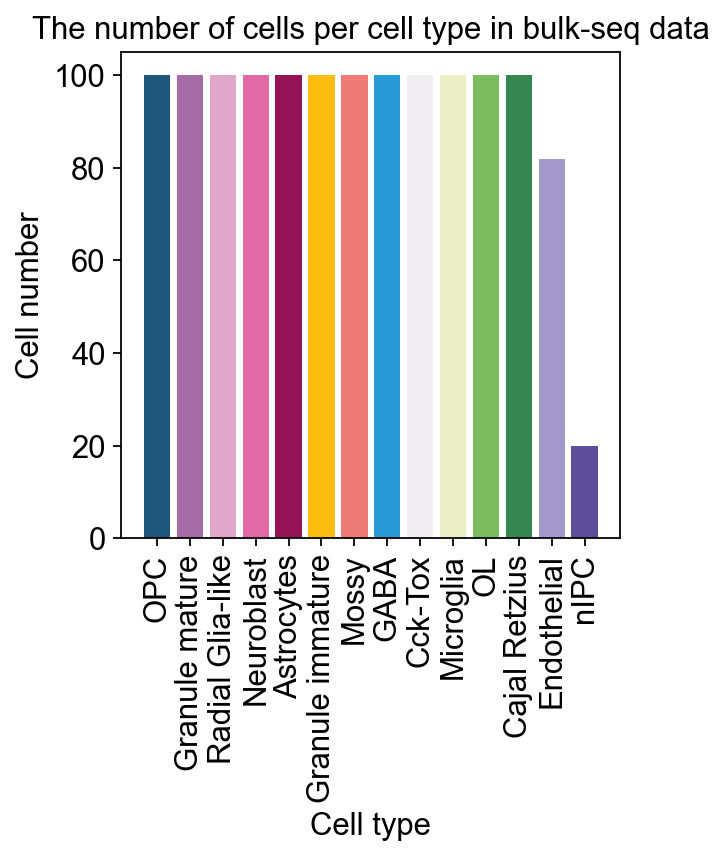

In [9]:
ov.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='clusters',
                                        )

## Visualize the generate scRNA-seq

To visualize the generate scRNA-seq’s learned embeddings, we use the pymde package wrapperin omicverse. This is an alternative to UMAP that is GPU-accelerated.

## Training the GNN model

Next, we used GNN to look for overlapping communities (community = cell type) in the generated single-cell data.

- gpu: The GPU ID for training the GNN model. Default is 0.
- hidden_size: The hidden size for the GNN model. Default is 128.
- weight_decay: The weight decay for the GNN model. Default is 1e-2.
- dropout: The dropout for the GNN model. Default is 0.5.
- batch_norm: Whether to use batch normalization for the GNN model. Default is True.
- lr: The learning rate for the GNN model. Default is 1e-3.
- max_epochs: The maximum epoch number for training the GNN model. Default is 500.
- display_step: The display step for training the GNN model. Default is 25.
- balance_loss: Whether to use the balance loss for training the GNN model. Default is True.
- stochastic_loss: Whether to use the stochastic loss for training the GNN model. Default is True.
- batch_size: The batch size for training the GNN model. Default is 2000.
- num_workers: The number of workers for training the GNN model. Default is 5.

In [10]:
bulktb.gnn_configure(max_epochs=2000,use_rep='X',
                     neighbor_rep='X_pca')

torch have been install version: 2.7.0+cu118
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


There are many parameters that can be controlled during training, here we set them all to the default

- thresh: the threshold for filtered the overlap community
- gnn_save_dir: the save dir for gnn model
- gnn_save_name: the gnn model name to save


In [12]:
bulktb.gnn_train()

Epoch  899, loss.full = 0.1563, nmi = 0.68, coverage = 0.9627, conductance = 0.1261, density  = 1.934e-01, clust_coef  = 1.202e-03:  45%|████▌     | 900/2000 [03:36<02:33,  7.15it/s] 

Breaking due to early stopping at epoch 900


Epoch  899, loss.full = 0.1563, nmi = 0.68, coverage = 0.9627, conductance = 0.1261, density  = 1.934e-01, clust_coef  = 1.202e-03:  45%|████▌     | 900/2000 [03:39<04:27,  4.11it/s]


......add nocd result to adata.obs
...save trained gnn in save_model/gnn.pth.


Since the previously generated single cell data has a random nature in the construction of the neighbourhood map, the model must be loaded on the fixed generated single cell data. Otherwise an error will be reported

In [13]:
bulktb.gnn_load('save_model/gnn.pth')

loading model from save_model/gnn.pth
......add nocd result to adata.obs


We can use GNN to get an overlapping community for each cell.

In [14]:
res_pd=bulktb.gnn_generate()
res_pd.head()

The nocd result is  nocd_OL                    100
nocd_GABA                   98
nocd_Astrocytes            102
nocd_Neuroblast            121
nocd_Cajal Retzius         111
nocd_Radial Glia-like      111
nocd_Mossy                  82
nocd_Endothelial            26
nocd_Microglia             100
nocd_Granule immature      143
nocd_Endothelial_1          70
nocd_Granule immature_1    119
nocd_OPC                   113
nocd_Cck-Tox               155
dtype: int64
The nocd result has been added to adata.obs['nocd_']


,nocd_OL,nocd_GABA,nocd_Astrocytes,nocd_Neuroblast,nocd_Cajal Retzius,nocd_Radial Glia-like,nocd_Mossy,nocd_Endothelial,nocd_Microglia,nocd_Granule immature,nocd_Endothelial_1,nocd_Granule immature_1,nocd_OPC,nocd_Cck-Tox
C_1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
C_2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
C_3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
C_4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
C_5,0,0,0,1,1,0,0,0,0,0,0,0,1,0


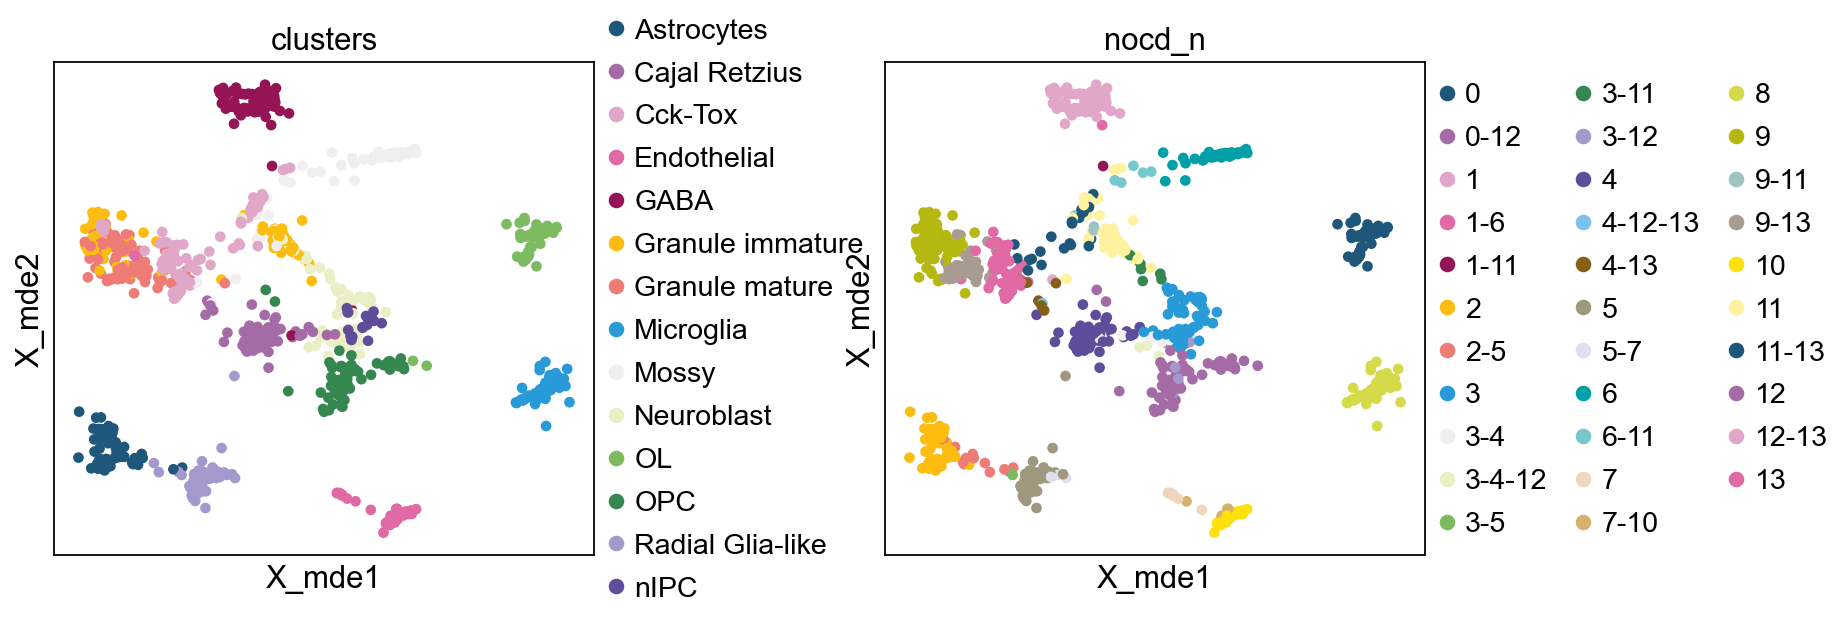

In [15]:
bulktb.nocd_obj.adata.obsm["X_mde"] = mde(bulktb.nocd_obj.adata.obsm["X_pca"])
sc.pl.embedding(bulktb.nocd_obj.adata,basis='X_mde',color=['clusters','nocd_n'],wspace=0.4,
          palette=ov.utils.pyomic_palette())

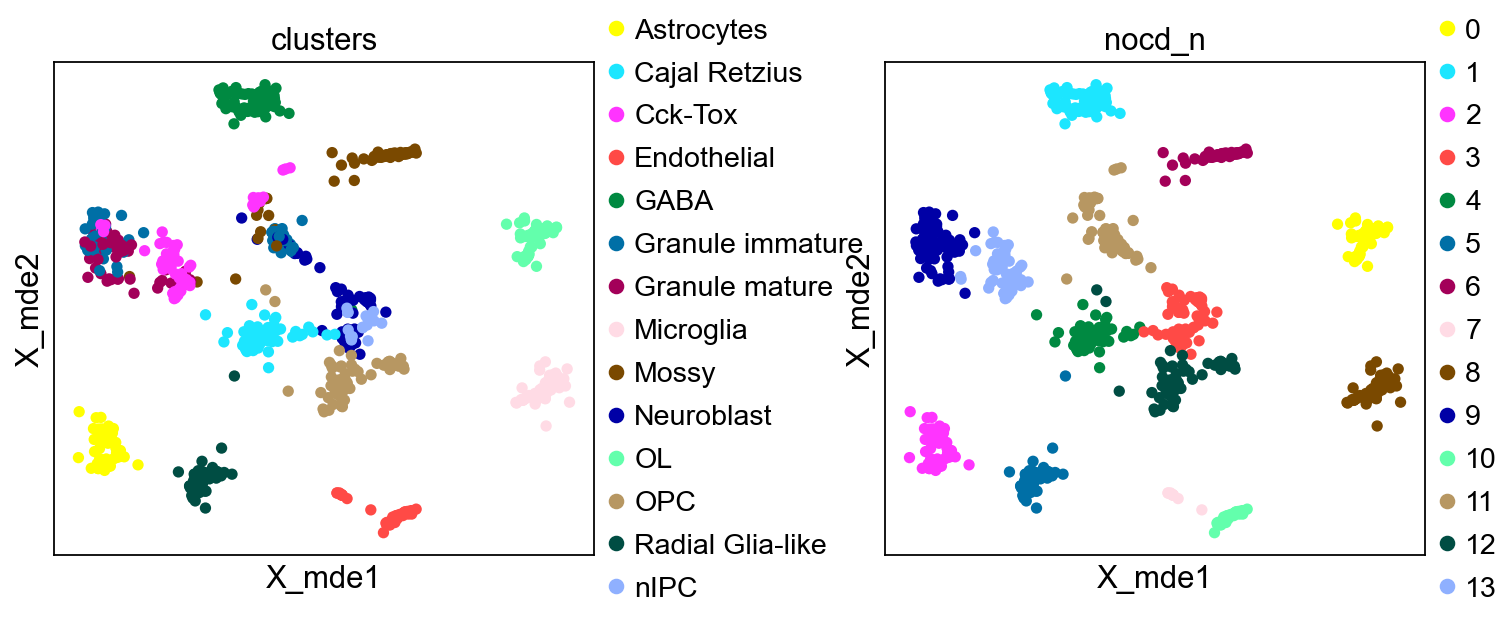

In [16]:
sc.pl.embedding(bulktb.nocd_obj.adata[~bulktb.nocd_obj.adata.obs['nocd_n'].str.contains('-')],
                basis='X_mde',
           color=['clusters','nocd_n'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

## Interpolation of the "interruption" cell

A simple function is provided to interpolate the "interruption" cells in the original data, making the single cell data continuous.

In [17]:
print('raw cells: ',bulktb.single_seq.shape[0])
#adata1=bulktb.interpolation('Neuroblast')
adata1=bulktb.interpolation('OPC')
print('interpolation cells: ',adata1.shape[0])

raw cells:  2930
interpolation cells:  3043


## Visualisation of single cell data before and after interpolation


In [18]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]
sc.pp.scale(adata1, max_value=10)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
sc.tl.pca(adata1, n_comps=100, svd_solver="auto")

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=100
    finished (0:00:02)


In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [21]:
sc.tl.pca(adata, n_comps=100, svd_solver="auto")

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=100
    finished (0:00:02)


In [22]:
adata.obsm["X_mde"] = mde(adata.obsm["X_pca"])
adata1.obsm["X_mde"] = mde(adata1.obsm["X_pca"])

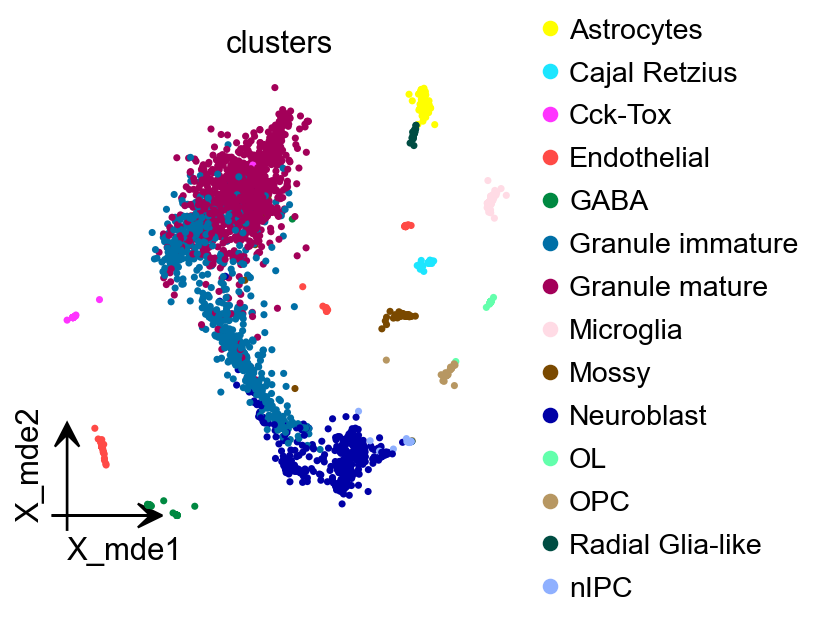

In [23]:
ov.utils.embedding(adata,
                basis='X_mde',
           color=['clusters'],
                   frameon='small',
           wspace=0.4,palette=sc.pl.palettes.default_102)

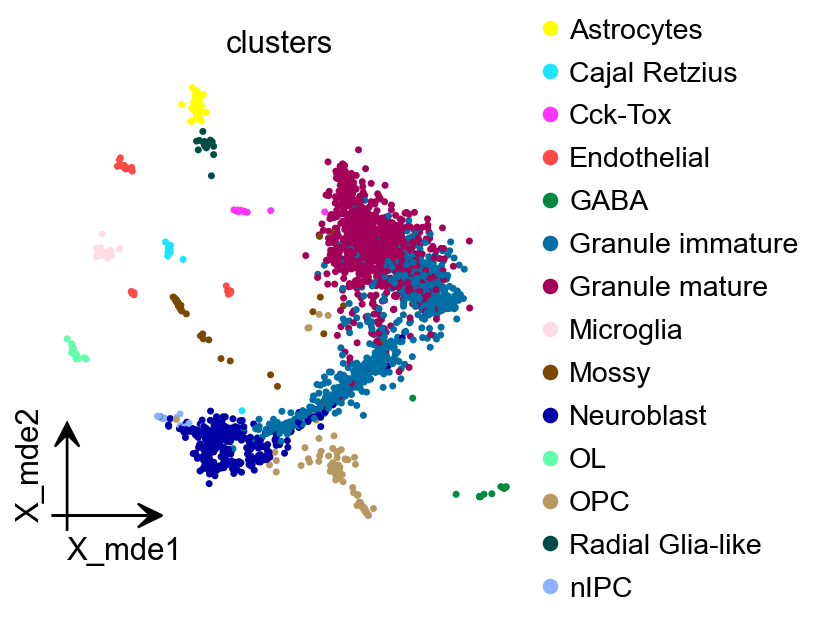

In [24]:
ov.utils.embedding(adata1,
                basis='X_mde',
           color=['clusters'],
                frameon='small',
           wspace=0.4,palette=sc.pl.palettes.default_102)

## Visualisation of the proposed time series trajectory of cells before and after interpolation

Here, we use pyVIA to complete the calculation of the pseudotime
.

In [ ]:
v0 = ov.single.pyVIA(adata=adata,adata_key='X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='clusters',knn=20,random_seed=4,root_user=['nIPC'],
                    dataset='group')
v0.run()

TypeError: VIA.__init__() got an unexpected keyword argument 'dist_std_local'

In [ ]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='clusters',knn=15,random_seed=4,root_user=['Neuroblast'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

Text(0.5, 1.0, 'Raw Dentategyrus')

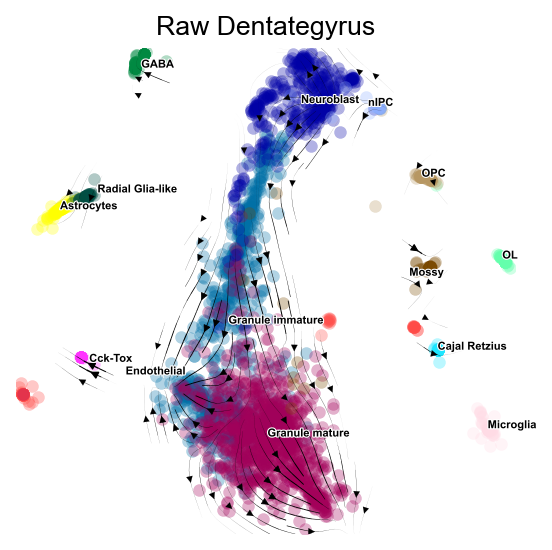

In [ ]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='clusters',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw Dentategyrus',fontsize=12)
#fig.savefig('figures/v0_via_fig4.png',dpi=300,bbox_inches = 'tight')

Text(0.5, 1.0, 'Interpolation Dentategyrus')

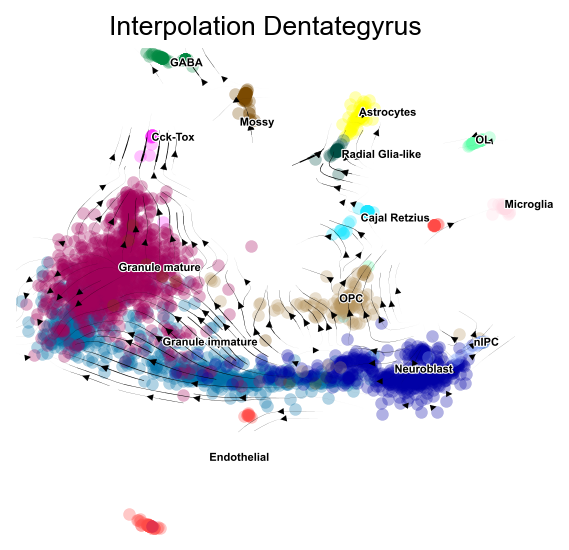

In [ ]:
fig,ax=v1.plot_stream(basis='X_mde',clusters='clusters',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Interpolation Dentategyrus',fontsize=12)
#fig.savefig('figures/v1_via_fig4.png',dpi=300,bbox_inches = 'tight')

Text(0.5, 1.0, 'Raw Dentategyrus\nPseudoTime')

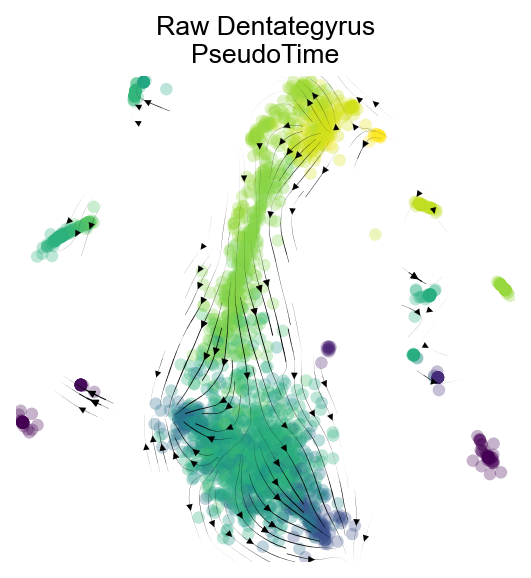

In [ ]:
fig,ax=v0.plot_stream(basis='X_mde',density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5,
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1,
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5)
plt.title('Raw Dentategyrus\nPseudoTime',fontsize=12)

Text(0.5, 1.0, 'Interpolation Dentategyru\nPseudoTime')

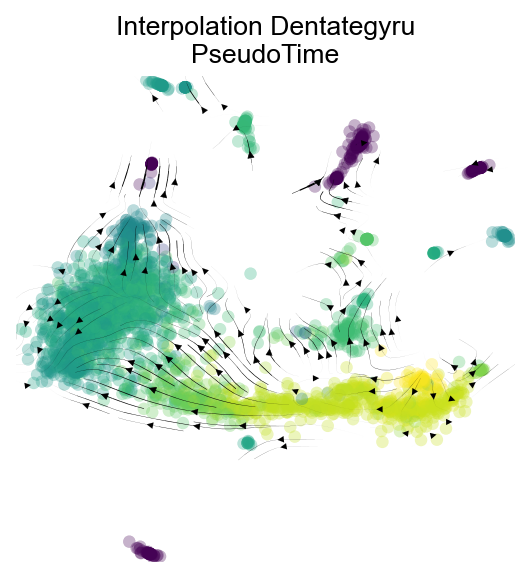

In [ ]:
fig,ax=v1.plot_stream(basis='X_mde',density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5,
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1,
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5)
plt.title('Interpolation Dentategyru\nPseudoTime',fontsize=12)

## PAGA Graph

To visualize the state transfer matrix, here we use PAGA to compute the state transfer diagram to further verify that our differentiation trajectory is valid

In [ ]:
v0.get_pseudotime(adata)
sc.pp.neighbors(adata,n_neighbors= 15,use_rep='X_pca')
ov.utils.cal_paga(adata,use_time_prior='pt_via',vkey='paga',
                 groups='clusters')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

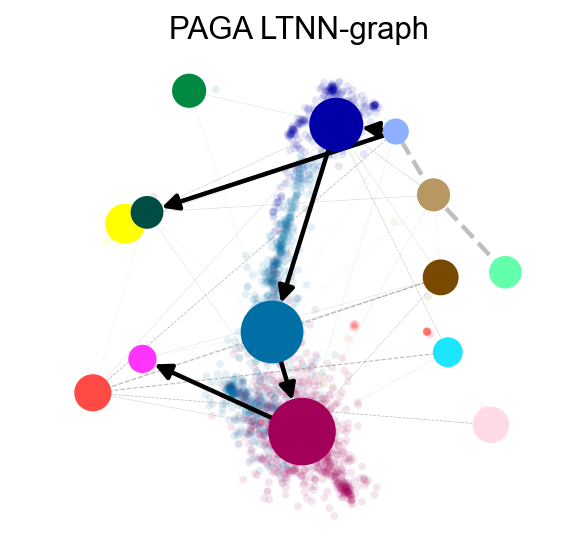

In [ ]:
ov.utils.plot_paga(adata,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

In [ ]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='clusters')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

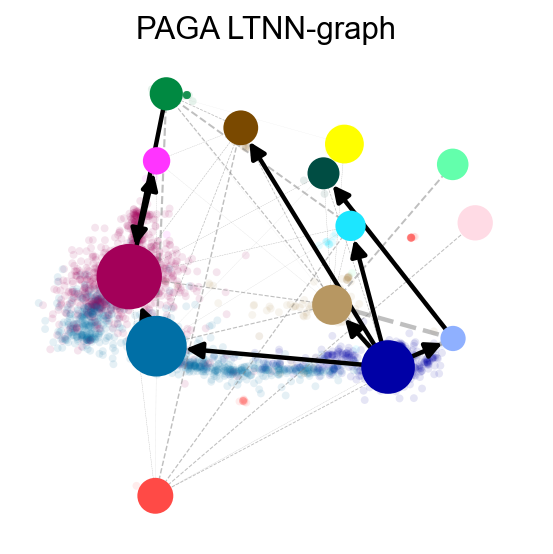

In [ ]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)